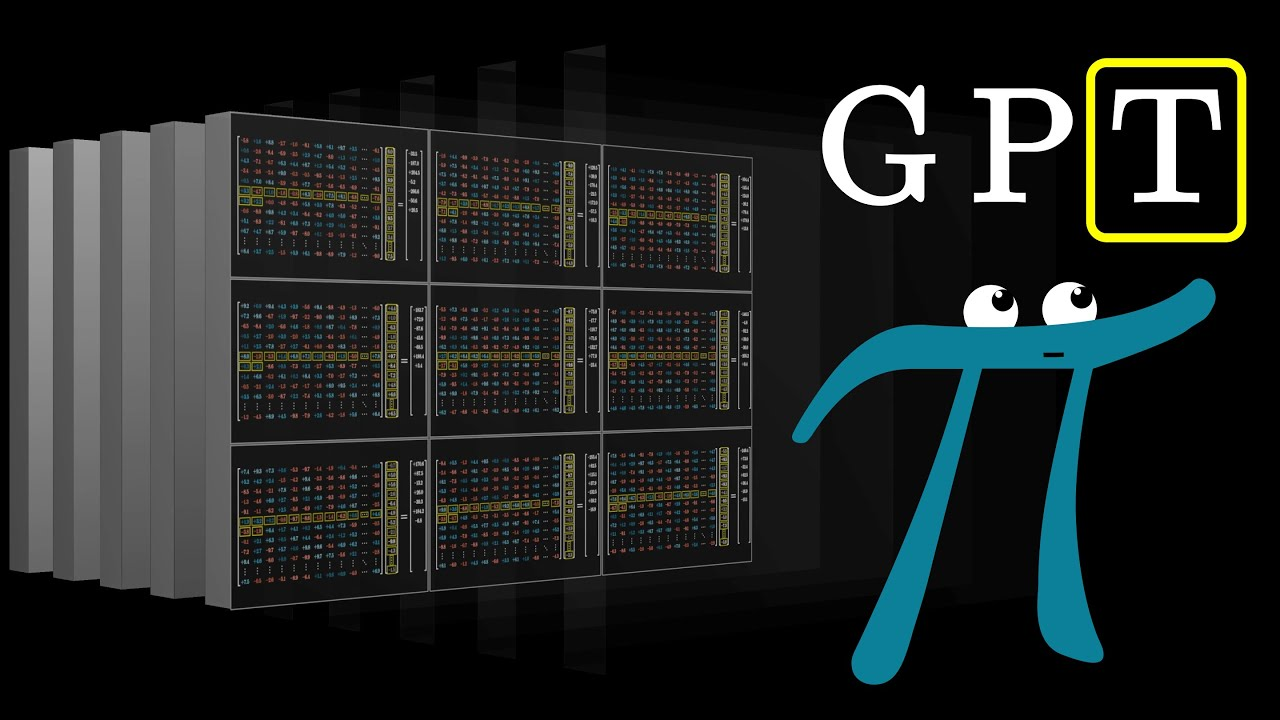

[Neural networks (3Blue1Brown) · Course](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=Z4aX4QoYJJe9gOiw)

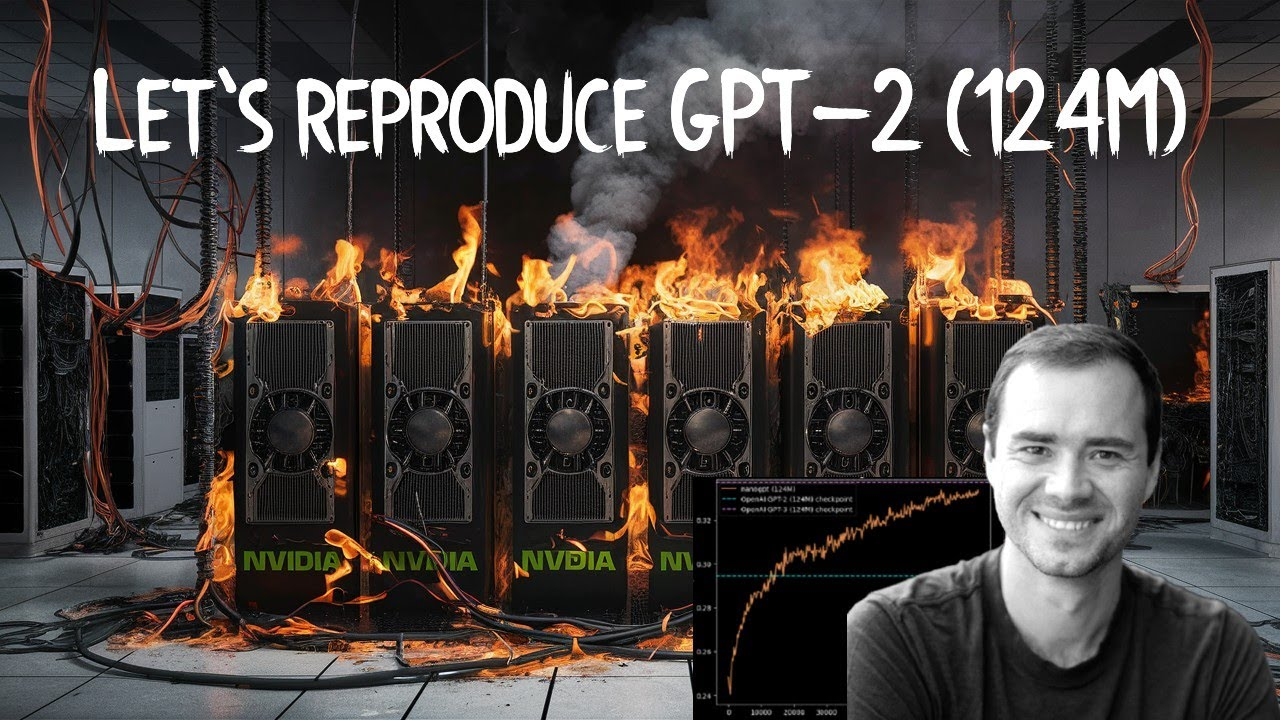

[Let's reproduce GPT-2 (124M)](https://youtu.be/l8pRSuU81PU)

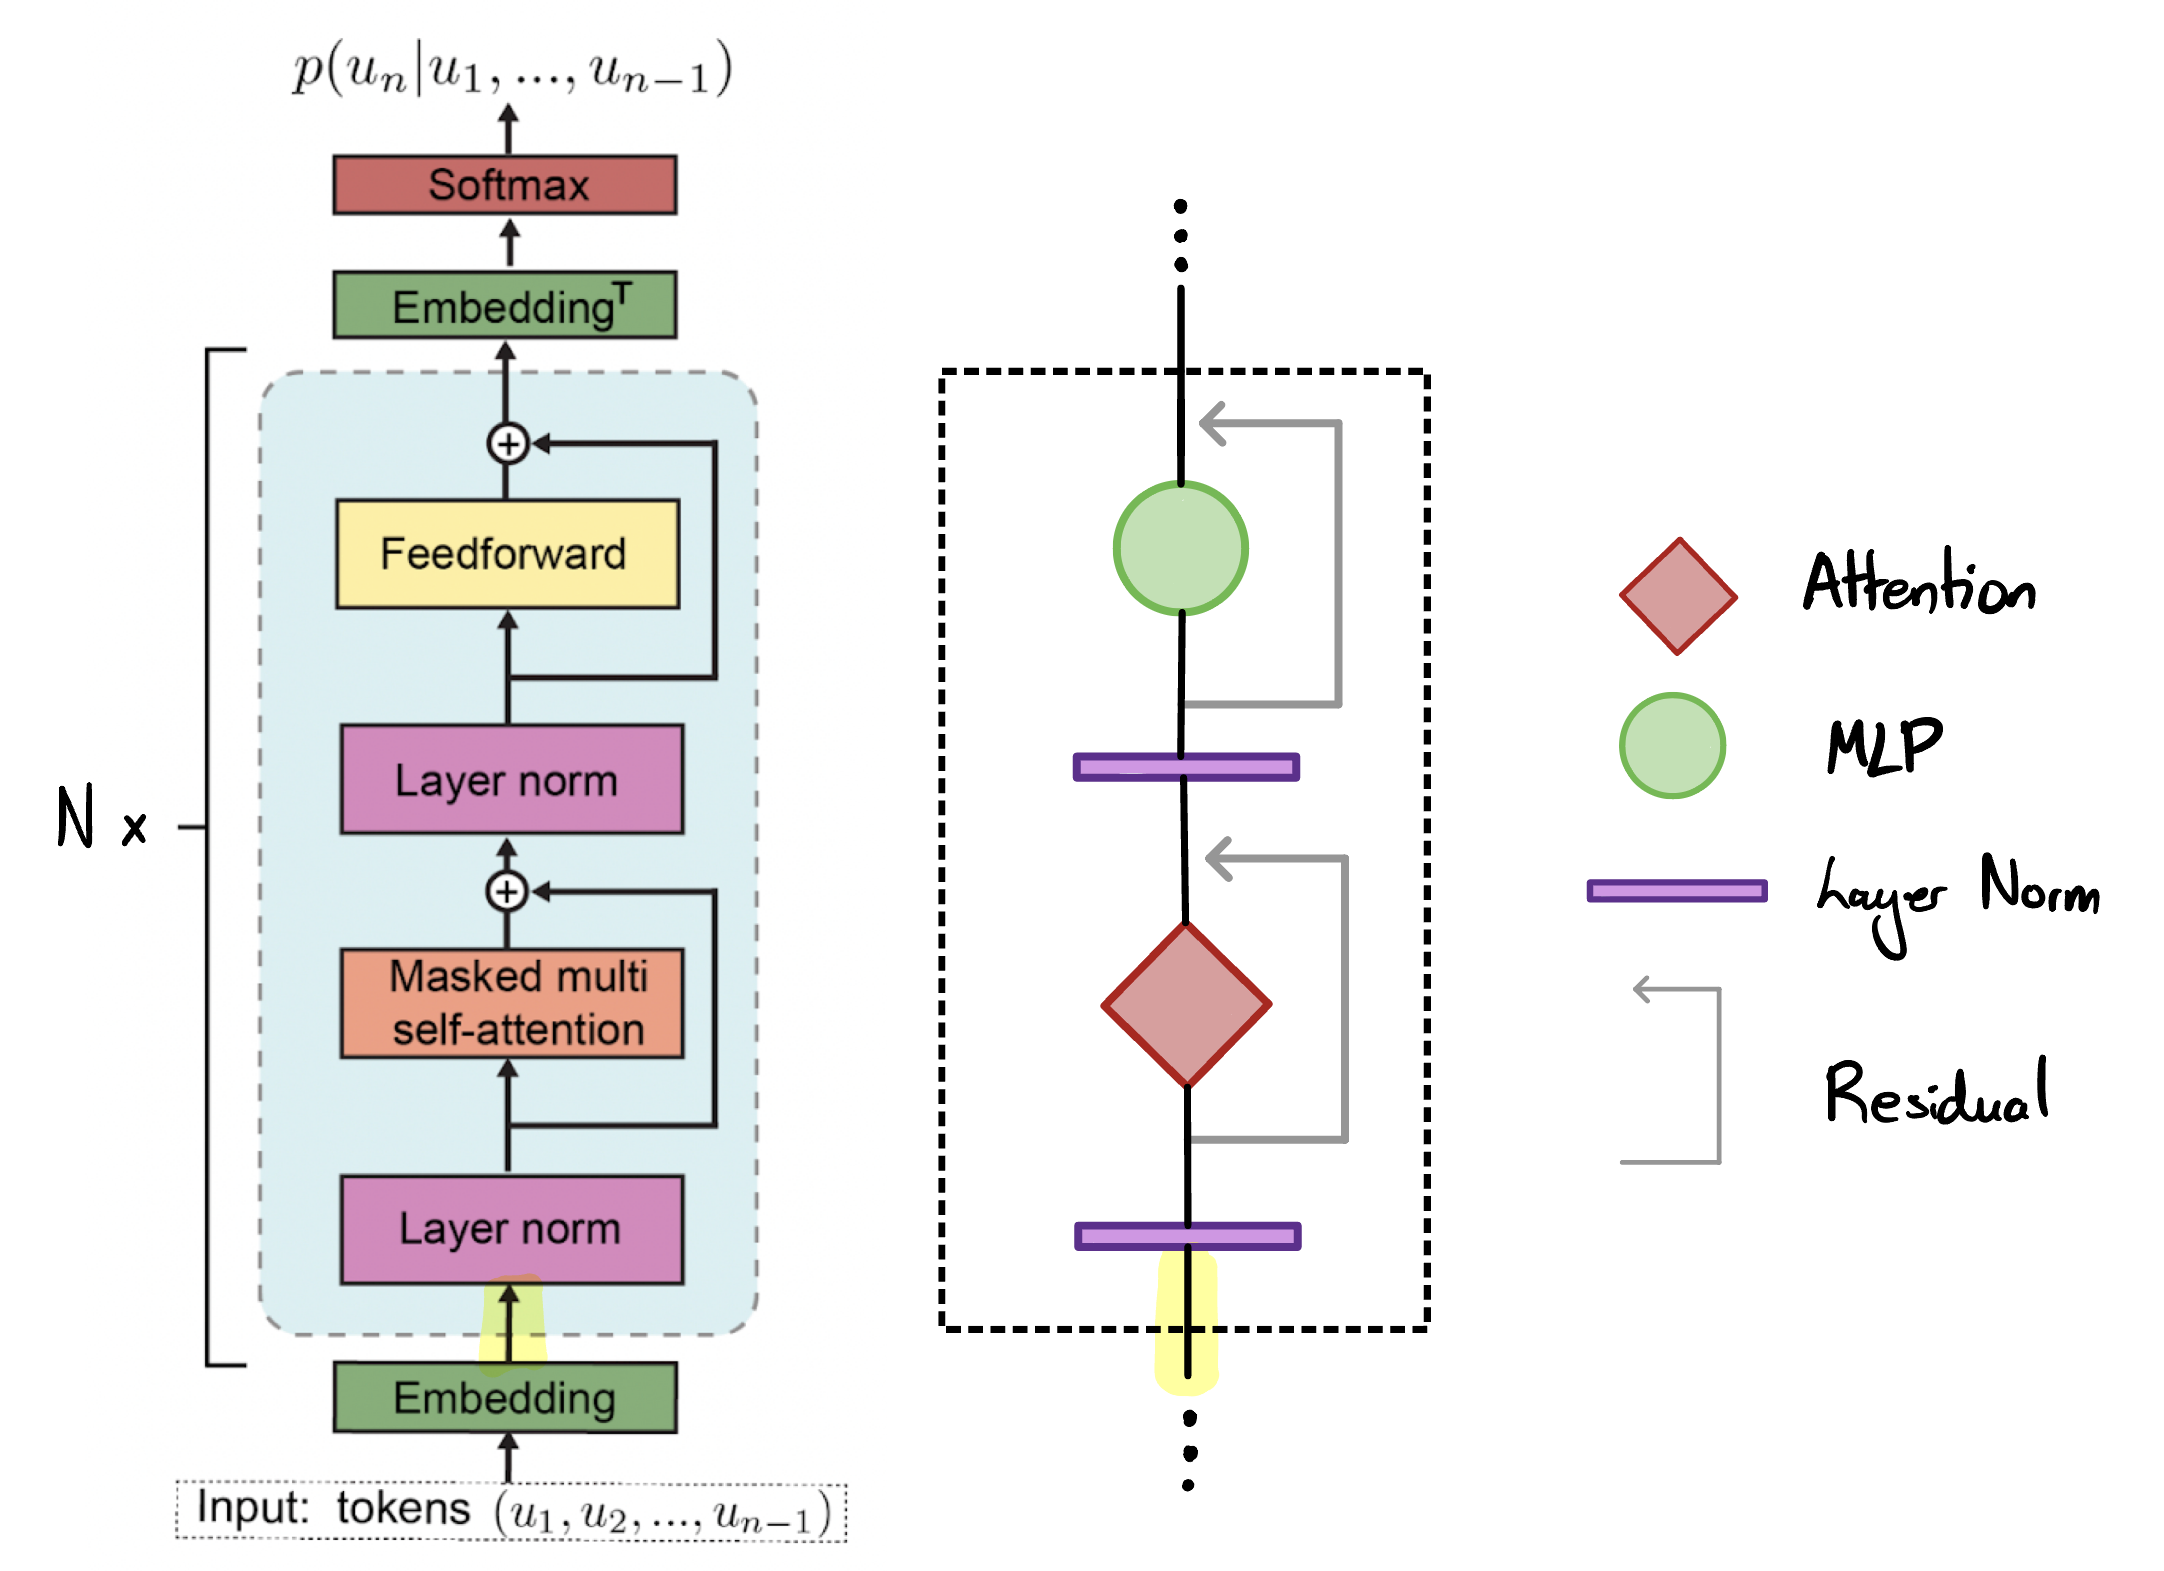

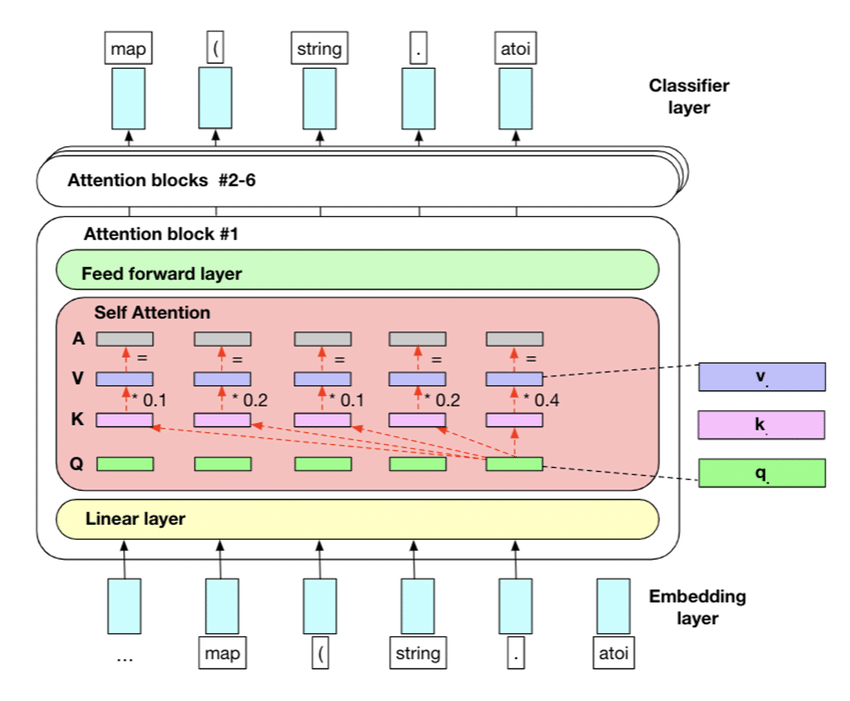

In [39]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

In [40]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        # x shape is [1, 8, 768]
        print("B, T, C = x.size() = ", x.size())
        B, T, C = x.size()  # batch, sequence length, embedding dimensionality (n_embd)
                            # C is the number of channels in the transformer meaning that the number of channels is equal to the embedding dimensionality
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads" hs is "head size" and C is (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh * hs=C=768 Channels in the transformer
        qkv = self.c_attn(x)
        print("qkv.size() = ", qkv.size()) # qkv.size() =  torch.Size([1, 8, 2304])
        q, k, v = qkv.split(self.n_embd, dim=2)
        print("q.size() = ", q.size()) # q.size() =  torch.Size([1, 8, 768])
        print("k.size() = ", k.size()) # k.size() =  torch.Size([1, 8, 768])
        print("v.size() = ", v.size()) # v.size() =  torch.Size([1, 8, 768])
        # q, k, v = [B, T, C] -> [B, T, 3, nh, hs] -> [B, nh, T, hs]
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs) View method is used to reshape the tensor from 3D to 4D 
                                                                        # then transpose method is used to swap the dimensions of the tensor.
                                                                        # meaning that the first dimension becomes the second, and the second dimension becomes the first.
                                                                        # This is done to make the tensor compatible with the matrix multiplication operation.
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        print("q.size() = ", q.size()) # q.size() =  torch.Size([1, 12, 8, 64])
        print("k.size() = ", k.size()) # k.size() =  torch.Size([1, 12, 8, 64])
        print("v.size() = ", v.size()) # v.size() =  torch.Size([1, 12, 8, 64])
        # this materializes the large (T,T) matrix for all the queries and keys
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
                                                                        # (1, 12, 8, 64) x (1, 12, 64, 8) -> (1, 12, 8, 8)
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # fill the upper triangle of the matrix with -inf for masking
                                                                        # to prevent the model from attending to future tokens
                                                                        # attending future tokens would cause the model to cheat and predict the next token
                                                                        # if the value of the mask is 0, the corresponding value in the attention matrix is replaced with -inf
        att = F.softmax(att, dim=-1) # (B, nh, T, T) softmax over the last dimension
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

In [41]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [42]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        ln_1_x = self.ln_1(x)
        print("LayerNorm ln_1_x", ln_1_x.shape, ln_1_x)
        x = x + self.attn(ln_1_x)
        x = x + self.mlp(self.ln_2(x))
        return x

In [43]:

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

In [44]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # language model head
   
    def forward(self, idx):
        device = idx.device
        print("idx: ", idx.shape, idx)
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        print("pos: ", pos.shape, pos, )

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        print("tok_emb: ", tok_emb.shape, tok_emb)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        print("pos_emb: ", pos_emb.shape, pos_emb)
        x = tok_emb + pos_emb
        print("x: ", x.shape, x)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)
        return logits, tok_emb, pos_emb, x

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        print("model.state_dict(): ", sd.keys())
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        print("model_hf.state_dict(): ", sd_hf.keys())
        # save to json file
        # import json
        # for k, v in sd_hf.items():
        #     print("k: ", k)
        #     with open("gpt_json/sd_hf_%s.json" % k, "w") as f:
        #         json.dump(v.cpu().numpy().tolist(), f, indent=4)                

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [45]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
elif hasattr(torch.backends, 'mps'):
  device = 'mps'
print("using device: %s" % device)

num_return_sequences = 1
max_length = 30

using device: mps


In [46]:
model = GPT.from_pretrained('gpt2')
model.eval()
model.to(device)

loading weights from pretrained gpt: gpt2
model.state_dict():  odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias',

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [47]:
# prefix tokens
import tiktoken

enc = tiktoken.get_encoding('gpt2')


In [9]:
# generate! right now x is (B, T) where B is the number of examples to generate and T is the length of the input sequence
# B is 5 and T is 8 in this case
# set the seed to 42 so we get the same results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [48]:
tokens = enc.encode("Hello, I'm a language model,")
print("Tokens for 'Hello, I'm a language model,':", tokens, len(tokens))

Tokens for 'Hello, I'm a language model,': [15496, 11, 314, 1101, 257, 3303, 2746, 11] 8


In [49]:

tokens = torch.tensor(tokens, dtype=torch.long) # convert to tensor (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)

In [33]:
x.shape # (5, 8) means we have 5 examples to generate, each with 8 tokens

torch.Size([1, 8])

In [50]:
logits, wte, pos, x = model(x)

idx:  torch.Size([1, 8]) tensor([[15496,    11,   314,  1101,   257,  3303,  2746,    11]],
       device='mps:0')
pos:  torch.Size([8]) tensor([0, 1, 2, 3, 4, 5, 6, 7], device='mps:0')
tok_emb:  torch.Size([1, 8, 768]) tensor([[[-0.0687, -0.1327,  0.0112,  ...,  0.0715, -0.0297, -0.0477],
         [ 0.0115, -0.0029,  0.0323,  ...,  0.0277, -0.0297, -0.0599],
         [ 0.0913, -0.0359,  0.0831,  ..., -0.0351, -0.1165, -0.0519],
         ...,
         [-0.0991, -0.0051,  0.0735,  ...,  0.1375,  0.2273, -0.0890],
         [-0.1501,  0.0382,  0.0712,  ...,  0.0239,  0.0075, -0.0909],
         [ 0.0115, -0.0029,  0.0323,  ...,  0.0277, -0.0297, -0.0599]]],
       device='mps:0', grad_fn=<EmbeddingBackward0>)
pos_emb:  torch.Size([8, 768]) tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02, 

In [80]:
logits[0].shape, wte[0].shape, pos.shape, x[0].shape

(torch.Size([8, 50257]),
 torch.Size([8, 768]),
 torch.Size([8, 768]),
 torch.Size([8, 768]))

In [51]:
logits[0].argmax(-1)

tensor([  11,  314, 1101, 7926, 1310, 5887,  263,  407], device='mps:0')

In [52]:
enc.decode(logits[0].argmax(-1).tolist())

", I'm sorry little experter not"

In [35]:
wte[0][0][:5], pos[0][:5], x[0][0][:5]

(tensor([-0.0687, -0.1327,  0.0112, -0.1467, -0.1842], device='mps:0',
        grad_fn=<SliceBackward0>),
 tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638], device='mps:0',
        grad_fn=<SliceBackward0>),
 tensor([-8.9804e-06, -1.4021e-01, -2.0845e-01, -2.8112e-02, -9.0179e-02],
        device='mps:0', grad_fn=<SliceBackward0>))

In [36]:
logits.shape

torch.Size([1, 8, 50257])

In [37]:
while x.size(1) < max_length:
  # forward the model to get the logits
  with torch.no_grad():
    logits = model(x) # logits is of shape (B, T, vocab_size)
    # take the logits at the last position
    logits = logits[:, -1, :] # logits is now of shape (B, vocab_size)
    # get the probabilities
    probs = F.softmax(logits, dim=-1)
    # sample from the distribution or take the most likely
    # do top-k sampling 50 default huggingface pipeline
    # topk_probs here becomes (5, 50) and topk_indices becomes (5, 50)
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    # select a token from the top-k options
    ix = torch.multinomial(topk_probs, 1) # ix is of shape (B, 1)
    # gather the corresponding indices
    xcol = topk_indices.gather(-1, ix) # xcol is of shape (B, 1)
    # append to the sequence
    x = torch.cat((x, xcol), dim=1) # x is of shape (B, T+1)

idx:  torch.Size([1, 8, 768]) tensor([[[-8.9804e-06, -1.4021e-01, -2.0845e-01,  ..., -1.5329e-01,
          -6.7826e-02, -1.9630e-01],
         [ 4.1949e-01,  2.3525e-01,  3.4816e-01,  ...,  4.5321e-02,
           1.5447e-01,  1.9546e-02],
         [-1.4148e-01, -3.0770e-01,  4.3753e-02,  ...,  2.4986e-02,
          -1.5816e-01,  1.5675e-01],
         ...,
         [-6.3677e-01,  7.1062e-01, -5.6322e-01,  ...,  5.7767e-01,
           3.0983e-01,  7.3162e-01],
         [-8.1747e-01, -9.0784e-02, -6.2061e-01,  ...,  4.8202e-01,
           2.0753e-01,  3.5372e-01],
         [ 5.0049e-02,  3.2800e-01, -6.6106e-01,  ...,  6.5927e-01,
          -1.7406e-01,  4.5575e-01]]], device='mps:0',
       grad_fn=<NativeLayerNormBackward0>)


ValueError: too many values to unpack (expected 2)

In [38]:
# print the generated sequences
for i in range(num_return_sequences):
  tokens = x[i, :max_length].tolist()
  decoded = enc.decode(tokens)
  print("> ", decoded)

TypeError: argument 'tokens': 'list' object cannot be interpreted as an integer